In [1]:
from netCDF4 import Dataset
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import math
import wget
import requests

from sklearn import cluster

from sklearn import preprocessing

import alphashape
from shapely.geometry import Polygon, Point, LineString

from sklearn import preprocessing

from descartes import PolygonPatch
import alphashape
import shapely

from sklearn.mixture import GaussianMixture
import matplotlib.patches as patches

import scipy.optimize as so
import os

import time
import pandas as pd

In [2]:
import os
os.chdir('C:\\Users\\yli48\\simple_house\\MyPhDProject\\Data_Driven_Uncertainty')

In [ ]:
def check_url_exists(url):
    try:
        response = requests.head(url, allow_redirects=True)
        return response.status_code == 200
    except requests.ConnectionError:
        return False

def download_file(url, path, file):
    if os.path.exists(file):
        os.remove(file)  # 删除已存在的文件
    wget.download(url, path)

In [ ]:
# dd_list = list(range(1,31)) # list(range(15,25)) + [27,28,29]
# mm_list = list(range(1,13))
# year = "2023"

# mm_dict = {}
# for mm in mm_list:
#     mm_dict[str(mm)] = dd_list.copy() #### store all days that have weather data

# for mm in mm_list:
#     dd_dict_copy = mm_dict[str(mm)].copy()  ### copy one dd_list to store all available days
#     for dd in dd_list:
#         url_nc = "https://ruisdael.citg.tudelft.nl/davis_weather_station/TUD_Green_Village/{year}{mm:02d}/{year}{mm:02d}{dd:02d}_Delft-davis-gv.nc".format(
#             year = year, mm = mm, dd = dd)
#         url_csv = "https://ruisdael.citg.tudelft.nl/davis_weather_station/TUD_Green_Village/{year}{mm:02d}/{year}{mm:02d}{dd:02d}_Delft-davis-gv.csv".format(
#             year = year, mm = mm, dd = dd)

#         if check_url_exists(url_nc):
#             path = "TUD_weather_data/gv"
#             file = path+"/{year}{mm:02d}{dd:02d}_Delft-davis-gv.nc".format(year = year, mm = mm, dd = dd)
#             download_file(url_nc, path, file)
#         elif check_url_exists(url_csv):
#             path = "TUD_weather_data/gv"
#             file = path+"/{year}{mm:02d}{dd:02d}_Delft-davis-csv.nc".format(year = year, mm = mm, dd = dd)
#             download_file(url_csv, path, file)
#         else:
#             if dd in mm_dict[str(mm)]:
#                 dd_dict_copy.remove(dd)
# #                print("\n"+str(mm)+str(dd))
#     mm_dict[str(mm)] = dd_dict_copy.copy()

In [ ]:
file_path = "TUD_weather_data/gv/20231219_Delft-davis-gv.nc"
file_obj = Dataset(file_path)
file_obj["solar_irradiance"][:].data - 10

In [ ]:
df = pd.read_csv("TUD_weather_data/gv/20230129_Delft-davis-gv.csv")
df.columns

In [ ]:
from more_itertools import chunked
import numpy.ma as ma
gv_data = pd.DataFrame(columns = ["YYYYMMDD", "HH", "T", "Q"]) ### time, temperature, and global radiation

hour = list(range(24))
for mm in mm_list:
    for dd in mm_dict[str(mm)]:
        temp = ma.array([])
        solar = ma.array([])
        YMD = np.array([])

        file_path_nc = "TUD_weather_data/gv/{year}{mm:02d}{dd:02d}_Delft-davis-gv.nc".format(year = year, dd = dd,mm = mm)
        file_path_csv = "TUD_weather_data/gv/{year}{mm:02d}{dd:02d}_Delft-davis-gv.csv".format(year = year, dd = dd,mm = mm)
        
        if os.path.exists(file_path_nc):            
            # file_path = "TUD_weather_data/gv/{year}{mm:02d}{dd:02d}_Delft-davis-gv.nc".format(year = year, dd = dd,mm = mm)
            file_obj = Dataset(file_path_nc)
    
            #### load air temperature ####
            if "out_air_temperature" in file_obj.variables.keys():
                _tep = file_obj.variables["out_air_temperature"][:]
            else:
                _tep = file_obj.variables["outTemp"][:]
    
            if 1440 - len(_tep) > 0:
                temp= np.concatenate((_tep, np.full(int(1440 - len(_tep)), _tep[-1])))
            else:
                temp = _tep[:1440]
    
            #### load solar irradiation ####
            if "solar_irradiance" in file_obj.variables.keys():
                _sol = file_obj.variables["solar_irradiance"][:]
            else:
                _sol = file_obj.variables["radiation"][:]
    
            if 1440 - len(_sol) > 0:
                solar = np.concatenate((_sol, np.full(int(1440 - len(_tep)), _sol[-1])))
            else:
                solar = _sol[:1440]
    

        elif os.path.exists(file_path_csv):
            size = os.path.getsize(file_path_csv)
            if size >= 500:
                df_csv = pd.read_csv(file_path_csv)
                _tep = df_csv["outTemp"].values
                _solar = df_csv["radiation"].values

                if 1440 - len(_tep) >0:
                    temp = np.concatenate((_tep, np.full(int(1440 - len(_tep)), _tep[-1])))
                else:
                    temp = _tep[:1440]


                if 1440 - len(_solar) >0:
                    solar = np.concatenate( (_solar, np.full(int(1440 - len(_solar)), _solar[-1])) )
                else:
                    solar = _solar[:1440]
            else: 
                continue

        Temp = np.array([ma.array(x).mean() for x in chunked(temp, 60)])
        Solar = np.array([ma.array(x).mean() for x in chunked(solar, 60)])
    
        for h in hour:
            new_row = pd.DataFrame({"YYYYMMDD": ["{year}{0:02d}{1:02d}".format(mm,dd,year = year)], "HH": [h], "T": [Temp[h]], "Q": [Solar[h]]})
            gv_data = pd.concat( (gv_data, new_row), ignore_index = True )
                


gv_data

In [ ]:
# gv_data.to_csv("gv_data.csv")

In [3]:
df_gv_data= pd.read_csv("gv_data.csv")
df_gv_data_copy = df_gv_data.copy()

############ fill the data that are missed with the previous data #############
# df_gv_data_copy["Q"] = df_gv_data["Q"].fillna(method = "ffill")
# df_gv_data_copy["T"] = df_gv_data["T"].fillna(method = "ffill")
# df_gv_data_copy

In [ ]:
df_knmi = pd.read_csv("uurgeg_344_2021-2030.txt", delimiter = ",")
df_knmi

In [ ]:
df_knmi_2023 = df_knmi[ (df_knmi["YYYYMMDD"].values >= 20230101) & (df_knmi["YYYYMMDD"].values <= 20240101)]

In [ ]:
df_knmi_2023["T"] = df_knmi_2023['    T'].values * 0.1
df_knmi_2023["Q"] = df_knmi_2023['    Q'].values * 1e4/3600

In [4]:
#df_knmi_2023.to_csv("knmi_2023.csv")
df_knmi_2023 = pd.read_csv("knmi_2023.csv")

In [5]:
gv_unique = df_gv_data_copy.drop_duplicates(subset = ["YYYYMMDD"])
gv_unique

Unnamed: 0  YYYYMMDD  HH          T    Q
0              0  20230128   0   3.888889  0.0
24            24  20230129   0   3.757407  0.0
48            48  20230130   0        NaN  NaN
72            72  20230201   0   7.437037  0.0
96            96  20230202   0   8.421296  0.0
...          ...       ...  ..        ...  ...
7296        7296  20231226   0  11.083331  0.0
7320        7320  20231227   0   4.009259  0.0
7344        7344  20231228   0        NaN  NaN
7368        7368  20231229   0   9.879628  0.0
7392        7392  20231230   0   8.787963  0.0

[309 rows x 5 columns]

In [6]:
knmi_temp = np.array([])
knmi_solar = np.array([])

gv_temp = df_gv_data_copy["T"].values
gv_solar = df_gv_data_copy["Q"].values

for yydd in gv_unique["YYYYMMDD"]:
    knmi_temp = np.append(knmi_temp, df_knmi_2023["T"][df_knmi_2023["YYYYMMDD"] == int(yydd)])
    knmi_solar = np.append(knmi_solar, df_knmi_2023["Q"][df_knmi_2023["YYYYMMDD"] == int(yydd)])
    

In [8]:
#plt.figure()
fig, ax = plt.subplots(2,1, figsize = (6,4))

ax[0].plot(knmi_temp, c = "r", linewidth = 0.6)
ax[0].legend(["KNMI"])
ax[0].set_ylabel("temperature ($^oC$)")

ax[1].plot(gv_temp, c = "b", linewidth = 0.6)
ax[1].legend(["TGV"])
ax[1].set_ylabel("temperature ($^oC$)")
ax[1].set_xlabel("time (hour)")
fig.savefig("temp.png", bbox_inches = "tight")

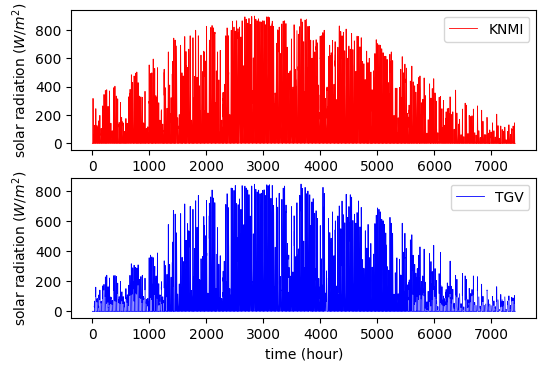

In [9]:
fig, ax = plt.subplots(2,1, figsize = (6,4))

ax[0].plot(knmi_solar, c = "r", linewidth = 0.6)
ax[0].legend(["KNMI"])
ax[0].set_ylabel("solar radiation ($W/m^2$)")

ax[1].plot(gv_solar, c = "b", linewidth = 0.6)
ax[1].legend(["TGV"])
ax[1].set_ylabel("solar radiation ($W/m^2$)")
ax[1].set_xlabel("time (hour)")
fig.savefig("solar.png", bbox_inches = "tight")

In [ ]:
def solar_predict(Solar, Ta):
    Am = 0
    theta_m = 28/360 * 2* np.pi
    As = 265/360*2*np.pi
    a_s = 30/360*2*np.pi
    lamb = -0.0038
    T_NOCT = 45
    Pr = 327
    
    # Sm_DNI = S_DNI*(np.sin(theta_m) * np.cos(a_s) * np.cos(Am - As) + np.cos(theta_m) * np.sin(a_s))
    # Sm_DHI = S_DHI*(1+ np.cos(theta_m))/2
    # Sm = Sm_DHI + Sm_DNI 
    Sm = Solar
    
    T_cell = Ta + Sm/800*(T_NOCT - 20)
    P_m = Pr*Sm/1000*(1 - lamb*(T_cell - 25))
    
    return P_m

In [ ]:
res_pred = solar_predict(knmi_solar, knmi_temp)
res_true = solar_predict(gv_solar, gv_temp)
res_error = (res_pred - res_true)#*2000/327
plt.plot(res_error)

In [ ]:
np.min(res_error)

In [ ]:
# plt.plot(res_error,".")
# plt.scatter(res_error, solar_error)
plt.plot(res_pred)
plt.plot(res_true)

In [ ]:
temp_error = knmi_temp - df_gv_data_copy["T"].values
solar_error = (knmi_solar - df_gv_data_copy["Q"].values)
#solar_error_scaled = solar_error

In [ ]:
solar_error_scaled = np.zeros(len(solar_error))
solar_error_scaled[knmi_solar > 0] = solar_error[knmi_solar >0]/knmi_solar[knmi_solar > 0] 

In [ ]:
plt.plot(solar_error_scaled)
np.min(solar_error_scaled)

In [ ]:
plt.scatter(temp_error, solar_error, s =1)
plt.xlabel("temp error")
plt.ylabel("solar error")
plt.savefig("temp_solar_orig.png")

In [ ]:
plt.scatter(solar_error_scaled, res_error_scaled, s =1)
plt.ylabel("solar error")
plt.savefig("temp_solar_orig.png")

In [ ]:
res_error_scaled = np.zeros(len(res_error))
res_error_scaled[res_pred > 0] = res_error[res_pred > 0]/res_pred[res_pred > 0]
plt.plot(res_error_scaled)
print(np.max(res_error_scaled))

In [ ]:
temp_error = np.nan_to_num(temp_error)
solar_error_scaled = np.nan_to_num(solar_error_scaled)
res_error_scaled = np.nan_to_num(res_error_scaled)

error_mat = np.concatenate((temp_error.reshape(-1,1), solar_error_scaled.reshape(-1,1), res_error_scaled.reshape(-1,1)), axis = 1)

In [ ]:
temp_error = np.nan_to_num(temp_error)
solar_error = np.nan_to_num(solar_error)
res_error = np.nan_to_num(res_error)

error_mat_raw = np.concatenate((temp_error.reshape(-1,1), solar_error.reshape(-1,1), res_error.reshape(-1,1)), axis = 1)

In [ ]:
np.save("train_data_raw.npy", error_mat_raw)

In [ ]:
error_mat.shape

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(temp_error, solar_error_scaled, res_error_scaled)
plt.show

In [ ]:
#solar_error_scaled[solar_error_scaled <= -1] = -1 
plt.scatter(temp_error/5, solar_error_scaled, s = 0.1)

In [ ]:
error_mat.shape

In [ ]:
2520/24